In [4]:
import struct
import numpy as np
import cv2
import matplotlib.pyplot as plt

# reading dataset

In [1]:
def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


In [3]:
images,labels = read_hoda_cdb('Train 60000.cdb')

(36, 28)


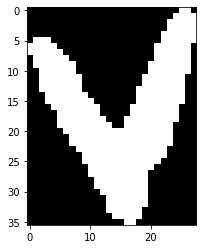

In [16]:
print(images[4].shape)
plt.imshow(images[4],cmap='gray')

# change image shape

In [61]:
new_images = []
for i in range(len(images)):
    img = images[i]
    if img.shape[0]%3 == 2 :
        arr = np.zeros(img.shape[1])
        img = np.vstack((img,arr))
    if img.shape[0]%3 == 1 :
        arr = np.zeros(img.shape[1])
        img = np.vstack((img,arr))
        img = np.vstack((img,arr))
    if img.shape[1]%3 == 2 :
        arr = np.zeros((img.shape[0],1))
        img = np.hstack((img,arr))
    if img.shape[1]%3 == 1 :
        arr = np.zeros((img.shape[0],1))
        img = np.hstack((img,arr))
        img = np.hstack((img,arr))
    new_images.append(img)

In [65]:
for i in range(len(new_images)):
    if new_images[i].shape[0]%3 != 0:
        print('no')
    if new_images[i].shape[1]%3 != 0:
        print('no')

# canny operation

In [71]:
import cv2 as cv

newnew_images = []
for i in range(len(new_images)):
    img = np.uint8(new_images[i])
    edges = cv.Canny(img,100,200)
    newnew_images.append(edges)

# devide each image to nine equal part and computing chain code histogram for each part

In [129]:
from PIL import Image

image_parts = []
img_feature = np.zeros((len(newnew_images),72))

for t in range(len(newnew_images)):
    im = Image.fromarray(newnew_images[t])
    imgwidth, imgheight = im.size
    height = int(imgheight/3)
    width = int(imgwidth/3)
    list_part = []
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            box = (j, i, j+width, i+height)
            a = im.crop(box)
            list_part.append(a)
    part_feature = np.zeros((9,8))      
    for h in range(len(list_part)):
        if np.mean(np.asarray(list_part[h])) == 0:
            part_feature[h,:] = [0,0,0,0,0,0,0,0]
        else:
            codes = fenc.encode_freeman(np.asarray(list_part[h]))
        one_count = 0
        two_count = 0
        three_count = 0
        four_count = 0
        five_count = 0
        six_count = 0
        seven_count = 0
        zero_count = 0
        for z in range(len(codes)):
            num = int(codes[z])
            if num ==0:
                zero_count+=1
            elif num==1:
                one_count+=1
            elif num==2:
                two_count+=1
            elif num == 3:
                three_count+=1
            elif num == 4:
                four_count+=1
            elif num ==5:
                five_count+=1
            elif num==6:
                six_count+=1
            elif num==7:
                seven_count+=1
        part_feature[h,:] = [zero_count/(len(codes)+1),one_count/(len(codes)+1),two_count/(len(codes)+1),three_count/(len(codes)+1),four_count/(len(codes)+1),five_count/(len(codes)+1),six_count/(len(codes)+1),seven_count/(len(codes)+1)]
    part_feature = part_feature.ravel(order='C')
    img_feature[t,:] = part_feature
                


In [ ]:
img_parts = np.zeros((len(newnew_images),9))
my_list

part_img = np.zeros(9)
for i in range(len(image_parts)):
    for j in range(9):
        part_img[j] = image_parts[i]

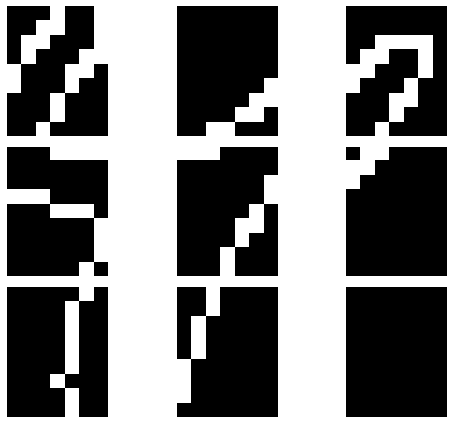

In [80]:
%matplotlib inline
fig, axes = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(8,6)
axes[0,0].imshow(image_parts[0], cmap=plt.cm.gray)
axes[0,1].imshow(image_parts[1], cmap=plt.cm.gray)
axes[0,2].imshow(image_parts[2], cmap=plt.cm.gray)
axes[1,0].imshow(image_parts[3], cmap=plt.cm.gray)
axes[1,1].imshow(image_parts[4], cmap=plt.cm.gray)
axes[1,2].imshow(image_parts[5], cmap=plt.cm.gray)
axes[2,0].imshow(image_parts[6], cmap=plt.cm.gray)
axes[2,1].imshow(image_parts[7], cmap=plt.cm.gray)
axes[2,2].imshow(image_parts[8], cmap=plt.cm.gray)
for ax in axes.ravel():
    ax.set_axis_off()
fig.tight_layout()
plt.show()

In [116]:
import numpy
import math
from skimage import measure
from copy import deepcopy, copy
import cv2
import matplotlib.pyplot as plt

class FreemanEncoder(object):
    '''
    classdocs
    '''
    #Class global variables
    #WATCH_OUT! The +x is right, but +y is down, so the representation is different from normal quadrants 
#     FREEMAN_DICT = {-90:'0', -45:'1', 0:'2', 45:'3', 90:'4', 135:'5', 180:'6', -135:'7'}
    FREEMAN_DICT = {-90:'4', -45:'3', 0:'2', 45:'1', 90:'0', 135:'7', 180:'6', -135:'5'}
    ALLOWED_DIRECTIONS = numpy.array([0, 45, 90, 135, 180, -45, -90, -135])

    def __init__(self):
        '''
        Constructor
        '''
        
    def find_nearest(self, array, value):
        '''
        Find the nearest element of array to the given value
        '''
        idx = (numpy.abs(array-value)).argmin()
        return array[idx]
    
    def encode_freeman(self, image_array):
        '''
        Encode the image contour in an 8-direction freeman chain code based on angles
        '''
        image_copy = copy(image_array)
        image_contour = self.get_contours(image_copy)
        freeman_code = ""
        
        for i in range(len(image_contour) - 1):
            delta_x = image_contour[i+1][0] - image_contour[i][0] 
            delta_y = image_contour[i+1][1] - image_contour[i][1]
            angle = math.degrees(math.atan2(delta_y,delta_x))
            angle = self.find_nearest(self.ALLOWED_DIRECTIONS, angle)
            
#             if not(delta_x == 0 and delta_y == 0):
#                 freeman_code += self.FREEMAN_DICT[angle]
                
            if delta_x == 0 and delta_y == 0:
                pass
            elif delta_x > 0 and delta_y == 0:
                freeman_code += '2'
            elif delta_x < 0 and delta_y == 0:
                freeman_code += '6'
            elif delta_x == 0 and delta_y > 0:
                freeman_code += '4'
            elif delta_x == 0 and delta_y < 0:
                freeman_code += '0'
            elif delta_x > 0 and delta_y > 0:
                freeman_code += '3'
            elif delta_x > 0 and delta_y < 0:
                freeman_code += '1'
            elif delta_x < 0 and delta_y > 0:
                freeman_code += '5'
            elif delta_x < 0 and delta_y < 0:
                freeman_code += '7'    
                
#             # normalize the code
#             freeman_code = self.normalize_freemancode(freeman_code)
#         print freeman_code
#         print image_contour[0],image_contour[1],image_contour[2] 
#         plt.imshow(image_array)
#         plt.show()
        
        return freeman_code
    
    def get_contours(self, image_array):
        #Extract the longest contour in the image
        contours, hierarchy = cv2.findContours(image_array,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
        
#         contours = measure.find_contours(image_array, 0.9, positive_orientation='high')
        contours_main = max(contours, key=len)
        contours_main = [item for sublist in contours_main for item in sublist] #only for the v2 method
        
        return contours_main
    
    def encode_freeman_dataset(self, images_dataset):
        '''
        Encode images dataset (given as a dictionary where keys are classes, 
        and values are the arrays of images, into a freeman code dictionary of 
        the same structure
        '''
        freeman_code_dict = dict((key, []) for key in images_dataset.keys())
        for key in images_dataset:
            for image in images_dataset[key]:
                image_freeman = self.encode_freeman(image)
                freeman_code_dict[key].append(image_freeman)
                
        return freeman_code_dict
#         return self.pad_codes(freeman_code_dict)
    
    def count_bagofwords(self, string, bagofwords=set(FREEMAN_DICT.values())):
        bagofwords_count = []
        for char in bagofwords:
            char_count = string.count(char)
            bagofwords_count.append(char_count)
            
        return bagofwords_count
    
    def gen_bagofwords_dict(self, freeman_code_dict):
        bagofwords_dict = dict((key, []) for key in freeman_code_dict.keys())
        for key in freeman_code_dict:
            for code in freeman_code_dict[key]:
                code_bagofwords_count = self.count_bagofwords(code)
                bagofwords_dict[key].append(code_bagofwords_count)
                
        return bagofwords_dict
    
    def normalize_freemancode(self,code):
        min_code = min(code)
        while code[0] != min_code:
            code = code[1:] + code[:1]
         

        return code
    
    def pad_codes(self, codes_dict):
        max_len = max(map(len,codes_dict.values()))
        
        padded_codes_dict = deepcopy(codes_dict)
        for key in codes_dict:
            codes = [x.zfill(max_len) for x in codes_dict[key]]
            padded_codes_dict[key] = codes
            
        return padded_codes_dict
                


# add relative feature

In [254]:
relative_features = np.zeros((len(images)))
for i in range(len(images)):
    img = images[i]
    relative_feature = (img.shape[0]*img.shape[1])/2000
    relative_features[i] = relative_feature

In [255]:
img_ff = img_feature
new_img_feature= np.hstack((img_ff,relative_features.reshape(60000,1)))

In [256]:
new_img_feature.shape

(60000, 73)

# add white-black transition feature

In [252]:
tr_v1 = np.zeros((len(images)))
for i in range(len(images)):
    img = images[i]
    counter = 0
    for y in range(img.shape[1]):
        for t in range(img.shape[0]):
            if img[t,y]==0:
                counter +=1
            else:
                break
    tr_v1[i] = counter/(img.shape[0]*img.shape[1])
                
            

In [257]:
new_img_feature = np.hstack((new_img_feature,tr_v1.reshape(60000,1)))
new_img_feature.shape

(60000, 74)

In [258]:
tr_h1 = np.zeros((len(images)))
tr_h2 = np.zeros((len(images)))

for i in range(len(images)):
    img = images[i]
    first_half = img[0:int(img.shape[0]/2),:]
    second_half = img[int(img.shape[0]/2):,:]
    counter_h1 = 0
    counter_h2 = 0
    
    for t in range(first_half.shape[0]):
        for y in range(first_half.shape[1]):
            if first_half[t,y]==0:
                counter_h1 +=1
            else:
                break
    tr_h1[i] = counter_h1/(int(img.shape[0]/2)*img.shape[1])
    
    for t in range(second_half.shape[0]):
        for y in range(second_half.shape[1]):
            if second_half[t,y]==0:
                counter_h2 +=1
            else:
                break
    tr_h2[i] = counter_h2/(int(img.shape[0]/2)*img.shape[1])

In [259]:
new_img_feature= np.hstack((new_img_feature,tr_h1.reshape(60000,1)))
new_img_feature= np.hstack((new_img_feature,tr_h2.reshape(60000,1)))
new_img_feature.shape

(60000, 76)

In [262]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert

skeletons = []
for i in range(len(images)):
    img = images[i]
    img = img.clip(max=1)
    # perform skeletonization
    skeleton = skeletonize(img)
    skeletons.append(skeleton)

In [267]:
tr_v2 = np.zeros((len(skeletons)))
for i in range(len(skeletons)):
    img = skeletons[i]
    counter = 0
    transotion_num = 0
    for y in range(img.shape[1]):
        for t in range(img.shape[0]):
            if img[t,y]==0:
                counter +=1
            elif img[t,y]==1 :
                transotion_num+=1
                counter +=1
            elif transotion_num==2:
                break
    tr_v2[i] = counter/(img.shape[0]*img.shape[1])

In [268]:
tr_v3 = np.zeros((len(skeletons)))
for i in range(len(skeletons)):
    img = skeletons[i]
    counter = 0
    transotion_num = 0
    for y in range(img.shape[1]):
        for t in range(img.shape[0]):
            if img[t,y]==0:
                counter +=1
            elif img[t,y]==1 :
                transotion_num+=1
                counter +=1
            elif transotion_num==3:
                break
    tr_v3[i] = counter/(img.shape[0]*img.shape[1])

In [269]:
new_img_feature= np.hstack((new_img_feature,tr_v2.reshape(60000,1)))
new_img_feature= np.hstack((new_img_feature,tr_v3.reshape(60000,1)))
new_img_feature.shape

(60000, 78)

In [270]:
tr_h12 = np.zeros((len(images)))
tr_h22 = np.zeros((len(images)))

for i in range(len(images)):
    img = images[i]
    first_half = img[0:int(img.shape[0]/2),:]
    second_half = img[int(img.shape[0]/2):,:]
    
    counter_h1 = 0
    transition_num = 0
    for t in range(first_half.shape[0]):
        for y in range(first_half.shape[1]):
            if first_half[t,y]==0:
                counter_h1 +=1
            elif first_half[t,y]==1 :
                counter_h1 +=1
                transition_num +=1
            elif transition_num==2:
                break
    tr_h12[i] = counter_h1/(int(img.shape[0]/2)*img.shape[1])
    
    counter_h2 = 0
    transition_num_1 = 0
    for t in range(second_half.shape[0]):
        for y in range(second_half.shape[1]):
            if second_half[t,y]==0:
                counter_h2 +=1
            elif second_half[t,y]==1:
                counter_h2 +=1
                transition_num_1+=1
            elif transition_num_1==2:
                break
    tr_h22[i] = counter_h2/(int(img.shape[0]/2)*img.shape[1])

In [271]:
new_img_feature= np.hstack((new_img_feature,tr_h12.reshape(60000,1)))
new_img_feature= np.hstack((new_img_feature,tr_h22.reshape(60000,1)))
new_img_feature.shape

(60000, 80)

In [272]:
tr_h12 = np.zeros((len(images)))
tr_h22 = np.zeros((len(images)))

for i in range(len(images)):
    img = images[i]
    first_half = img[0:int(img.shape[0]/2),:]
    second_half = img[int(img.shape[0]/2):,:]
    
    counter_h1 = 0
    transition_num = 0
    for t in range(first_half.shape[0]):
        for y in range(first_half.shape[1]):
            if first_half[t,y]==0:
                counter_h1 +=1
            elif first_half[t,y]==1 :
                counter_h1 +=1
                transition_num +=1
            elif transition_num==3:
                break
    tr_h12[i] = counter_h1/(int(img.shape[0]/2)*img.shape[1])
    
    counter_h2 = 0
    transition_num_1 = 0
    for t in range(second_half.shape[0]):
        for y in range(second_half.shape[1]):
            if second_half[t,y]==0:
                counter_h2 +=1
            elif second_half[t,y]==1:
                counter_h2 +=1
                transition_num_1+=1
            elif transition_num_1==3:
                break
    tr_h22[i] = counter_h2/(int(img.shape[0]/2)*img.shape[1])

In [273]:
new_img_feature= np.hstack((new_img_feature,tr_h12.reshape(60000,1)))
new_img_feature= np.hstack((new_img_feature,tr_h22.reshape(60000,1)))
new_img_feature.shape

(60000, 82)

# classification

In [159]:
#without transition feature

In [164]:
from sklearn import svm
from sklearn.metrics import accuracy_score
clf = svm.SVC(C=100,kernel ='rbf', gamma=1)
clf.fit(img_feature[:50000,:], labels[:50000])
pred = clf.predict(img_feature[50000:,:])
accuracy_score(labels[50000:], pred)

0.9731

In [ ]:
#with transition feature

In [261]:
from sklearn import svm
clf = svm.SVC(C=100,kernel ='rbf', gamma=1)
clf.fit(new_img_feature[:50000,:], labels[:50000])
pred = clf.predict(new_img_feature[50000:,:])
accuracy_score(labels[50000:], pred)

0.9785

In [274]:
#with all transition feature
from sklearn import svm
clf = svm.SVC(C=100,kernel ='rbf', gamma=1)
clf.fit(new_img_feature[:50000,:], labels[:50000])
pred = clf.predict(new_img_feature[50000:,:])
accuracy_score(labels[50000:], pred)

0.9814